In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
from keras.optimizers.legacy import Adam, RMSprop #
import matplotlib.pyplot as plt
from keras.initializers import Constant
from sklearn import feature_extraction, linear_model, model_selection, preprocessing


In [6]:
train_df = pd.read_csv("data/nlp-getting-started/train.csv")
test_df = pd.read_csv("data/nlp-getting-started/test.csv")

# Brief description of the problem and data (5 pts)

- 10,000 tweets that were hand classified between being a disaster or not. 
- it’s not always clear whether a person’s words are actually announcing a disaster
-  you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified



# EDA

In [7]:
# POSITIVES
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
# NEGATIVES
train_df[train_df['target'] == 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


# Baseline Model  Ridge Classifier

Following Kaggle's tutorial

In [9]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

clf.fit(train_vectors, train_df["target"])
sample_submission = pd.read_csv("data/nlp-getting-started/sample_submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.head()


,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


# Model 2: Fine tuning BERT (Bidirectional encoder representations)

Based on Keras tutorial

In [109]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers.legacy import Adam
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.0
KerasNLP version: 0.8.2


In [110]:
# Preprocessing
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [117]:
from sklearn.model_selection import train_test_split

X = train_df["text"]
y = train_df["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
X_test = test_df["text"]

In [118]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )



In [119]:
# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2,
                                                               load_weights=True,
                                                               
                                                               )

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                           ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)                     │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ token_ids (InputLayer)                        │ (None, None)                           │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ distil_bert_backbone (DistilBertBackbone)     │ (None, None, 768)                      │      66,362,880 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ tf.__operators__.getitem_4 (SlicingOpLambda)  │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ pooled_dense (Dense)                          │ (None, 768)                            │         590,592 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ output_dropout (Dropout)                      │ (None, 768)                            │               0 │
├───────────────────────────────────────────────┼────────────────────────────────────────┼─────────────────┤
│ logits (Dense)                                │ (None, 2)                              │           1,538 │
└───────────────────────────────────────────────┴────────────────────────────────────────┴─────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
from keras.optimizers.legacy import Adam
 #Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=Adam(1e-5),
    metrics= ["accuracy"]  
)

# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/2
191/191 [==============================] - 1070s 6s/step - loss: 0.4883 - accuracy: 0.7833 - val_loss: 0.3961 - val_accuracy: 0.8391
Epoch 2/2
191/191 [==============================] - 1020s 5s/step - loss: 0.3735 - accuracy: 0.8493 - val_loss: 0.3860 - val_accuracy: 0.8431


191/191 [==============================] - 365s 2s/step


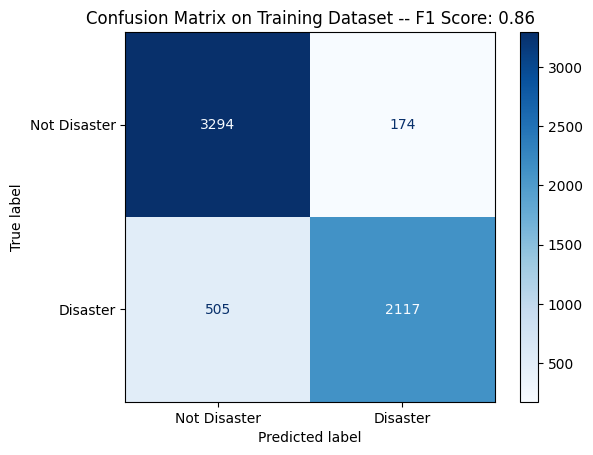

In [121]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 [==============================] - 97s 2s/step


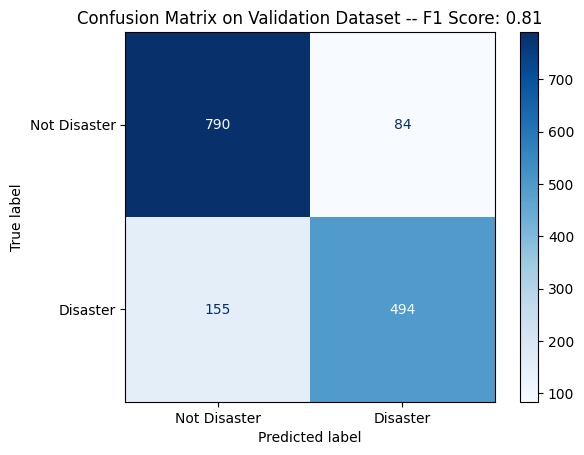

In [122]:
y_pred_val = classifier.predict(X_val)
displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [123]:
classifier.save_weights('distilbert.weights')

/Users/leon/Desktop/Rentier/repos/LeetCode-Solutions/venv/lib/python3.9/site-packages/keras_nlp/src/models/task.py:54: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/leon/Desktop/Rentier/repos/LeetCode-Solutions/venv/lib/python3.9/site-packages/keras_nlp/src/models/task.py:54: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/leon/Desktop/Rentier/repos/LeetCode-Solutions/venv/lib/python3.9/site-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr

In [63]:
sample_submission["target"] = np.argmax( classifier.predict(X_test), axis=1)
sample_submission.to_csv("submission_nlp.csv", index=False)

# function for text preprocessing
def text_preprocessing(text):
    
    # remove hyperlinks
    text = str(text)
    text = re.sub(r'((http|https)://\S+)', '', text)

    # ... and ..
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')  
        
    # Seperate words from punctuations 
    punctuations = '@#!.?+&*[]-%:/();$=><|{}^' + "'`"
    for p in punctuations:
        text  = text.replace(p, f' {p} ')

    return text

train_df['clean_text'] = train_df['text'].apply(text_preprocessing)
test_df['clean_text'] = test_df['text'].apply(text_preprocessing)

# Train_test split
TEST_SIZE=0.2
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(train_df, 
                                                      y, 
                                                      test_size=TEST_SIZE, 
                                                      random_state=100) 

# Training Bidirectional LSTM with word embeddings (learnt within data)

In [75]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import re 


VOCAB_SIZE = 21884
OOV_TOKEN ="<OOV>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, split=' ', oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train['clean_text'])
word_index = tokenizer.word_index

# Generate and pad sequences
sequences_train = tokenizer.texts_to_sequences(X_train['clean_text'].values)
padded_train = pad_sequences(sequences_train)
max_length = max(len(seq) for seq in padded_train)# Find maximum sequence length

sequences_val = tokenizer.texts_to_sequences(X_val['clean_text'].values)
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post')

sequences_test = tokenizer.texts_to_sequences(test_df['clean_text'].values)
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post')

print("Maximum sequence length:", max_length)

Maximum sequence length: 36


In [77]:
# Build the model 
# hyper-papameters
EMBEDDED_DIM =25
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT=64
LAYER2_UNIT=32
DROP_OUT1=0.8
DROP_OUTBI1=0.8
DROP_OUTBI2=0.8
NUM_EPOCHS = 10
BATCH_SIZE = 128


model3 = tf.keras.Sequential([

    # Using word embeddings learned via techniques like tf.keras.layers.Embedding can often improve the 
    # performance of NLP models by capturing semantic relationships between words and reducing the dimensionality 
    # of the input space. They are especially useful when dealing with large vocabularies and sparse representations of text data.
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDED_DIM,  input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LAYER2_UNIT,  dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
    tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
model3.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])


model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 25)            547100    
                                                                 
 bidirectional (Bidirection  (None, 36, 128)           46080     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 634461 (2.42 MB)
Trainable params: 634461 

In [80]:
# Train the model
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

history_model3 = model3.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE,
                           callbacks=early_stopping_callback)

Epoch 1/10
48/48 [==============================] - 19s 207ms/step - loss: 0.6877 - accuracy: 0.5599 - recall: 0.0596 - precision: 0.4182 - val_loss: 0.6822 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
48/48 [==============================] - 10s 204ms/step - loss: 0.6848 - accuracy: 0.5683 - recall: 0.0015 - precision: 0.2222 - val_loss: 0.6807 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/10
48/48 [==============================] - 11s 228ms/step - loss: 0.6794 - accuracy: 0.5709 - recall: 0.0069 - precision: 0.6000 - val_loss: 0.6714 - val_accuracy: 0.5719 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
48/48 [==============================] - 11s 231ms/step - loss: 0.6504 - accuracy: 0.6192 - recall: 0.1856 - precision: 0.7232 - val_loss: 0.6233 - val_accuracy: 0.6763 - val_recall: 0.8282 - val_precision: 0.5863
Epoch 5/10
48/48 [==============================] - 11s 230ms/step - loss: 0

/var/folders/nd/53p4z73n4_75sm5m7bcwsr3h0000gn/T/ipykernel_14592/806966355.py:21: RuntimeWarning: invalid value encountered in divide
  f1_val = 2*(r2*p2)/(r2+p2)


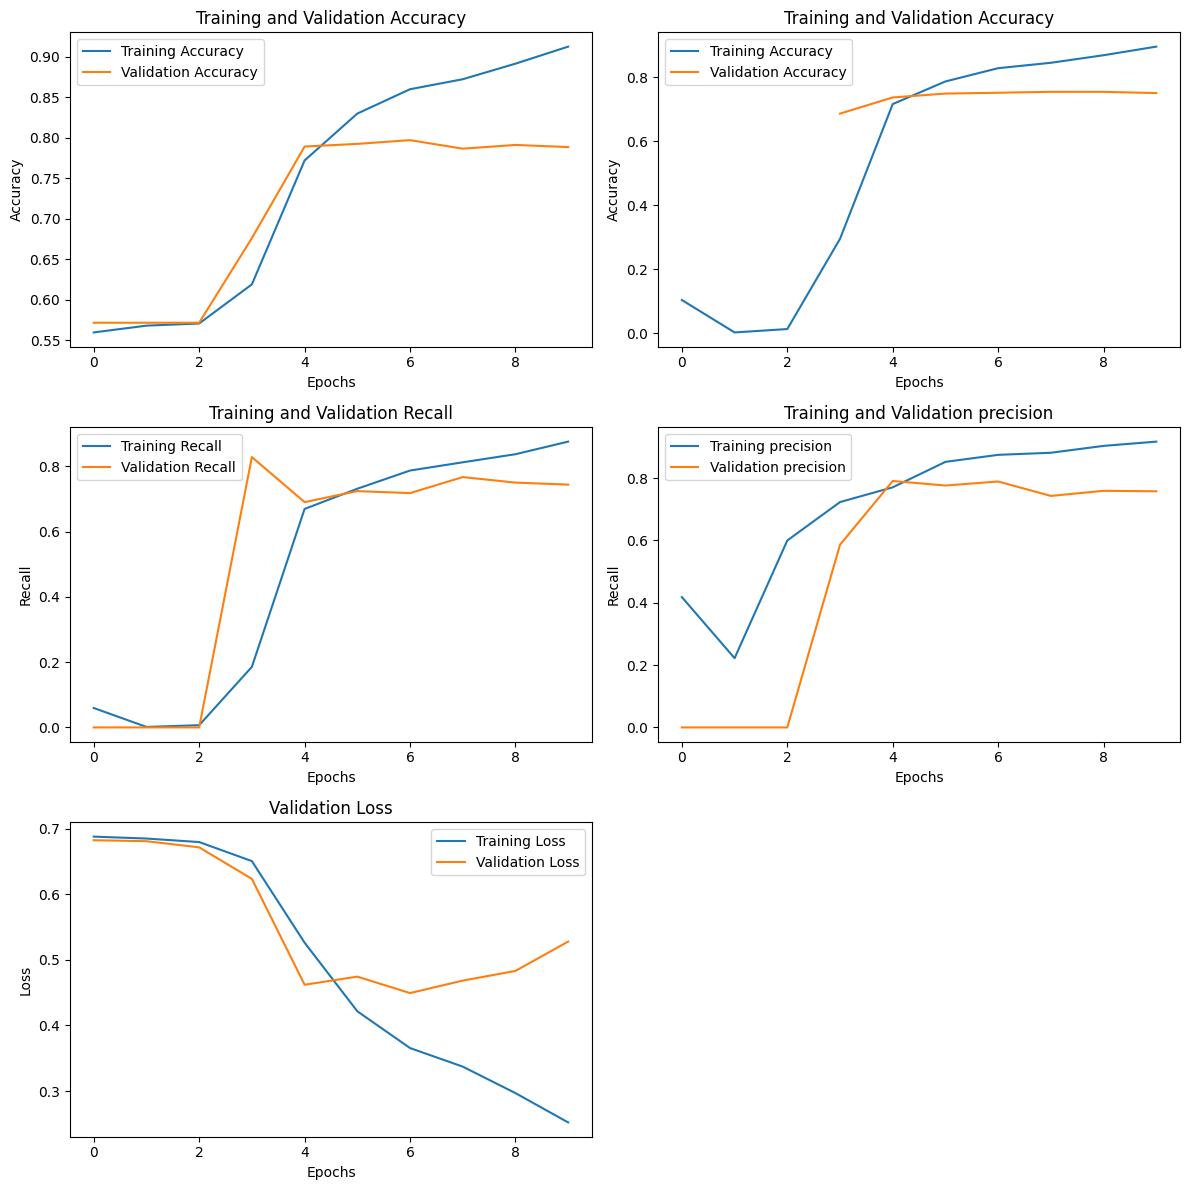

In [93]:
def plot_results(history):
    # Create a 3x2 subplot grid
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))

    # Plot training and validation accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Training and Validation Accuracy')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    # Plot training and validation accuracy
    r1 = np.array(history.history['recall'])
    p1 = np.array(history.history['precision'])
    r2 = np.array(history.history['val_recall'])
    p2 = np.array(history.history['val_precision'])
    f1 = 2*(r1*p1)/(r1+p1)
    f1_val = 2*(r2*p2)/(r2+p2)


    axes[0, 1].plot(f1, label='Training Accuracy')
    axes[0, 1].plot(f1_val, label='Validation Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot training and validation recall
    axes[1, 0].plot(history.history['recall'], label='Training Recall')
    axes[1, 0].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 0].set_title('Training and Validation Recall')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()

    # Plot training and validation recall
    axes[1, 1].plot(history.history['precision'], label='Training precision')
    axes[1, 1].plot(history.history['val_precision'], label='Validation precision')
    axes[1, 1].set_title('Training and Validation precision')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    # Plot validation loss
    axes[2, 0].plot(history.history['loss'], label='Training Loss', )
    axes[2, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[2, 0].set_title('Validation Loss')
    axes[2, 0].set_xlabel('Epochs')
    axes[2, 0].set_ylabel('Loss')
    axes[2, 0].legend()

    # Hide the empty subplot in the last row and second column
    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a `history` object returned from training your Keras model
# plot_results(history)



# Plot results
plot_results(history_model3)


In [94]:
# Training Bidirectional GRU with word embeddings from a pretrained embedding model (learnt within data)

In [97]:
glove_embeddings = np.load('glove.840B.300d.pkl', allow_pickle=True)
# Embedding matrix for GloVe word vectors

# get vacab size from embedding
VOCAB_SIZE = len(glove_embeddings)
EMBEDDED_DIM = len(next(iter(glove_embeddings.values())))
print('vacab size: ', VOCAB_SIZE ,'\n','embedding dim: ', EMBEDDED_DIM )

# Embeddomg matrix from tokenizer created before
embedding_matrix = np.zeros((VOCAB_SIZE,EMBEDDED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

vacab size:  2196008 
 embedding dim:  300


In [100]:
# Build the model 5

# hyper-papameters
MAX_LEN = max_length
LEARNING_RATE = 0.0005
DECAY_STEPS = 100 
DECAY_RATE = 0.5
LAYER1_UNIT,LAYER2_UNIT =64,64
DROP_OUT1,DROP_OUTBI1,DROP_OUTBI2 =0.3,0.3,0.3
NUM_EPOCHS = 18
BATCH_SIZE = 128

model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,
                    output_dim=EMBEDDED_DIM,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_length,
                    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LAYER1_UNIT, return_sequences=True,dropout=DROP_OUTBI1,recurrent_dropout=DROP_OUTBI1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(LAYER2_UNIT,    dropout=DROP_OUTBI2,recurrent_dropout=DROP_OUTBI2)),
     tf.keras.layers.Dropout(DROP_OUT1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model 
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)
model5.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 36, 300)           658802400 
                                                                 
 bidirectional_2 (Bidirecti  (None, 36, 128)           140544    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 659017569 (2.46 GB)
Trainable params: 21

In [101]:
# Train the model 
history_model5 = model5.fit(padded_train, y_train, epochs=NUM_EPOCHS, 
                            validation_data=(padded_val, y_val), 
                            batch_size=BATCH_SIZE, 
                            callbacks=[early_stopping_callback])

Epoch 1/18
48/48 [==============================] - 22s 256ms/step - loss: 0.6054 - accuracy: 0.6780 - recall: 0.4658 - precision: 0.6846 - val_loss: 0.5009 - val_accuracy: 0.7676 - val_recall: 0.6534 - val_precision: 0.7690
Epoch 2/18
48/48 [==============================] - 13s 269ms/step - loss: 0.4838 - accuracy: 0.7801 - recall: 0.7045 - precision: 0.7656 - val_loss: 0.4132 - val_accuracy: 0.8181 - val_recall: 0.6948 - val_precision: 0.8531
Epoch 3/18
48/48 [==============================] - 15s 318ms/step - loss: 0.4400 - accuracy: 0.8054 - recall: 0.7022 - precision: 0.8195 - val_loss: 0.4020 - val_accuracy: 0.8260 - val_recall: 0.7071 - val_precision: 0.8617
Epoch 4/18
48/48 [==============================] - 15s 310ms/step - loss: 0.4275 - accuracy: 0.8135 - recall: 0.7098 - precision: 0.8318 - val_loss: 0.3977 - val_accuracy: 0.8247 - val_recall: 0.7577 - val_precision: 0.8192
Epoch 5/18
48/48 [==============================] - 15s 319ms/step - loss: 0.4141 - accuracy: 0.8213

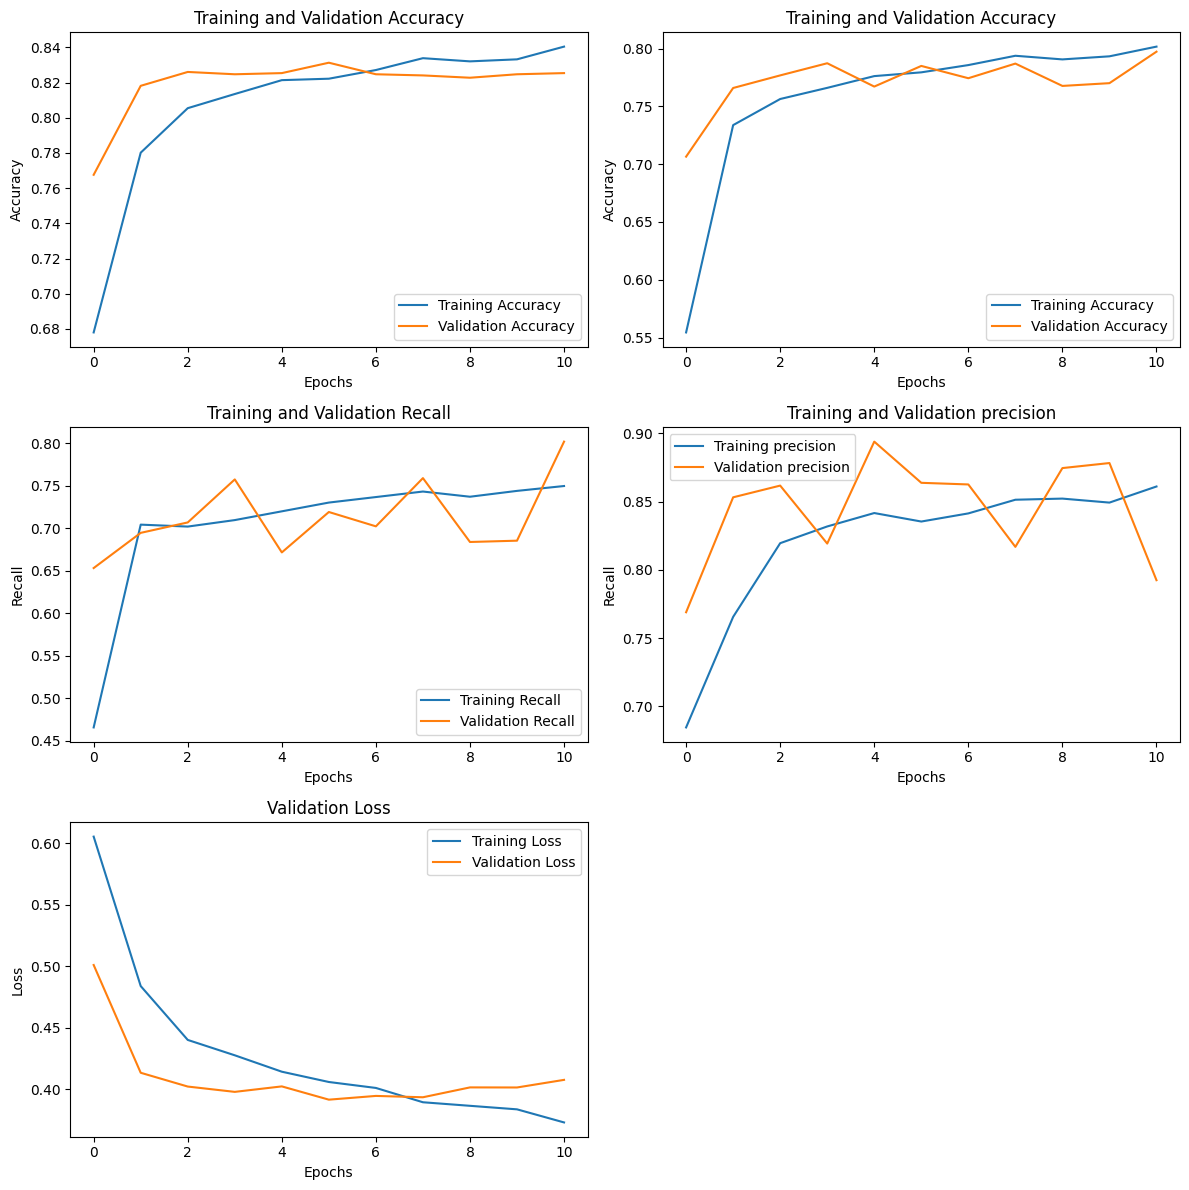

In [103]:
plot_results(history_model5)